In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Load the data into a DataFrame
df = pd.read_csv("./output/validation_results_entire_ATAC.bed", sep="\t", header=None)

# Columns: chromosome, start, end, cell_line, label, score
df.columns = ["chromosome", "start", "end", "cell_line", "label", "score"]

# Remove the 'tensor()' part from 'start' and 'end' columns
df['start'] = df['start'].str.extract(r'tensor\((\d+)\)').astype(int)
df['end'] = df['end'].str.extract(r'tensor\((\d+)\)').astype(int)

df.head()

,chromosome,start,end,cell_line,label,score
0,chr1,9997,10466,C4-2,Positive,1.810776
1,chr1,10007,11313,PC-3,Positive,2.246324
2,chr1,10007,11318,LNCAP,Positive,1.379589
3,chr1,10007,11318,LNCAP,Negative,1.379589
4,chr1,10007,11362,A549,Positive,1.579789


In [79]:
df['classified_label'] = df['score'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

df

,chromosome,start,end,cell_line,label,score,classified_label
0,chr1,9997,10466,C4-2,Positive,1.810776,Positive
1,chr1,10007,11313,PC-3,Positive,2.246324,Positive
2,chr1,10007,11318,LNCAP,Positive,1.379589,Positive
3,chr1,10007,11318,LNCAP,Negative,1.379589,Positive
4,chr1,10007,11362,A549,Positive,1.579789,Positive
...,...,...,...,...,...,...,...
762275,chrY,56746036,56746120,THP-1,Negative,-3.576924,Negative
762276,chrY,56746044,56746109,THP-1,Negative,-3.479884,Negative
762277,chrY,56756021,56756106,THP-1,Negative,-4.312430,Negative
762278,chrY,56756029,56756111,THP-1,Negative,-4.141182,Negative


In [80]:
# from itertools import combinations
# from tqdm import tqdm

# # Function to check overlap
# def is_overlap(row1, row2):
#     return row1['start'] < row2['end'] and row2['start'] < row1['end']

# # Evaluate each pair of cell lines
# results = []

# cell_lines = list(combinations(df['cell_line'].unique(), 2))

# for cell_line1, cell_line2 in tqdm(cell_lines, desc="Evaluating cell line pairs"):
#     overlap_count = 0
#     correct_classification_count = 0

#     for _, row1 in df[df['cell_line'] == cell_line1].iterrows():
#         for _, row2 in df[df['cell_line'] == cell_line2].iterrows():
#             if is_overlap(row1, row2):
#                 overlap_count += 1
#                 if row1['classified_label'] != row2['classified_label']:
#                     correct_classification_count += 1

#     if overlap_count > 0:
#         accuracy = correct_classification_count / overlap_count
#         results.append((cell_line1, cell_line2, overlap_count, correct_classification_count, accuracy))

# # Print the results
# for result in results:
#     print(f"Cell Line Pair: {result[0]} and {result[1]}, "
#           f"Overlaps: {result[2]}, "
#           f"Correct Classifications: {result[3]}, "
#           f"Accuracy: {result[4]:.2f}")

In [81]:
# Calculating accuracy: comparing the original label with the classified label
correct_predictions = (df['label'] == df['classified_label']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions * 100

accuracy

87.89775410610274

In [82]:
# Splitting the dataset
below_05 = df[df['score'] < 0.5]
above_or_equal_05 = df[df['score'] >= 0.5]

# Calculating min and max for each part
min_below_05, max_below_05 = below_05['score'].min(), below_05['score'].max()
min_above_05, max_above_05 = above_or_equal_05['score'].min(), above_or_equal_05['score'].max()

# Define scaling functions
def scale_below_05(score):
    return (score - min_below_05) / (max_below_05 - min_below_05) * 0.5

def scale_above_05(score):
    return 0.5 * (score - min_above_05) / (max_above_05 - min_above_05) + 0.5

# Apply the scaling functions
df.loc[df['score'] < 0.5, 'scaled_score'] = df['score'].apply(scale_below_05)
df.loc[df['score'] >= 0.5, 'scaled_score'] = df['score'].apply(scale_above_05)

df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score
0,chr1,9997,10466,C4-2,Positive,1.810776,Positive,0.564569
1,chr1,10007,11313,PC-3,Positive,2.246324,Positive,0.586024
2,chr1,10007,11318,LNCAP,Positive,1.379589,Positive,0.543329
3,chr1,10007,11318,LNCAP,Negative,1.379589,Positive,0.543329
4,chr1,10007,11362,A549,Positive,1.579789,Positive,0.553190
...,...,...,...,...,...,...,...,...
762275,chrY,56746036,56746120,THP-1,Negative,-3.576924,Negative,0.385919
762276,chrY,56746044,56746109,THP-1,Negative,-3.479884,Negative,0.388634
762277,chrY,56756021,56756106,THP-1,Negative,-4.312430,Negative,0.365337
762278,chrY,56756029,56756111,THP-1,Negative,-4.141182,Negative,0.370129


In [90]:
import pandas as pd
import numpy as np
threshold = 0.5

df['classified_label'] = df['scaled_score'].apply(lambda x: 'Positive' if x > threshold else 'Negative')

df = df[df['cell_line'] != 'LNCAP']

def calculate_mcc(TP, FP, FN, TN):
    # Calculate MCC, handling the case where the denominator is zero
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    if denominator == 0:
        return 0
    else:
        return (TP * TN - FP * FN) / denominator

def calculate_metrics(group):
    TP = ((group['label'] == 'Positive') & (group['classified_label'] == 'Positive')).sum()
    FP = ((group['label'] == 'Negative') & (group['classified_label'] == 'Positive')).sum()
    FN = ((group['label'] == 'Positive') & (group['classified_label'] == 'Negative')).sum()
    TN = ((group['label'] == 'Negative') & (group['classified_label'] == 'Negative')).sum()

    return TP, FP, FN, TN

# Apply the function to each cell line and calculate metrics
metrics = df.groupby('cell_line').apply(lambda group: pd.Series(calculate_metrics(group), index=['TP', 'FP', 'FN', 'TN']))

# Add a row for total
total_metrics = metrics.sum()
metrics.loc['Total'] = total_metrics

# Calculate Precision, Recall, FDR, and MCC for each row
metrics['Accuracy'] = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
metrics['Precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
metrics['Recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
metrics['FDR'] = metrics['FP'] / (metrics['FP'] + metrics['TP'])
metrics['MCC'] = metrics.apply(lambda row: calculate_mcc(row['TP'], row['FP'], row['FN'], row['TN']), axis=1)


print(metrics)


              TP     FP    FN      TN  Accuracy  Precision    Recall  \
cell_line                                                              
22Rv1       5120   5470  5837   87128  0.890812   0.483475  0.467281   
A549          42   9335    81  135960  0.935249   0.004479  0.341463   
C4-2       12054  17195  2055   99598  0.852943   0.412117  0.854348   
MCF7         714  18614   190  240060  0.927559   0.036941  0.789823   
PC-3         123   6267   139   61119  0.905304   0.019249  0.469466   
THP-1        304    106   100     943  0.858224   0.741463  0.752475   
Total      18357  56987  8402  624808  0.907715   0.243642  0.686012   

                FDR       MCC  
cell_line                      
22Rv1      0.516525  0.414401  
A549       0.995521  0.032812  
C4-2       0.587883  0.526423  
MCF7       0.963059  0.161093  
PC-3       0.980751  0.079952  
THP-1      0.258537  0.648500  
Total      0.756358  0.372537  


/var/folders/0m/90sjqm9d78l50t2x2lmdrztm0000gn/T/ipykernel_64028/390346470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_label'] = df['label'].map({'Positive': 1, 'Negative': 0})


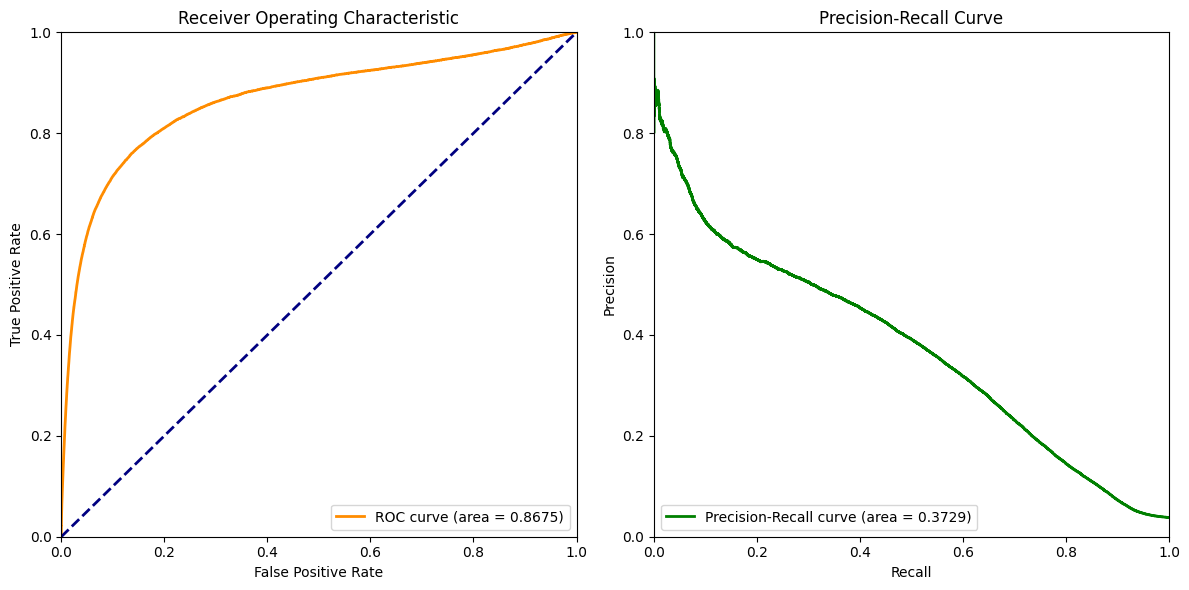

In [84]:

# Convert the 'label' column to binary format: 'Positive' to 1, 'Negative' to 0
df['binary_label'] = df['label'].map({'Positive': 1, 'Negative': 0})

# Use the scaled scores and true labels
y_true = df['binary_label']
y_scores = df['scaled_score']


# Compute Precision-Recall curve and area
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plotting both ROC and Precision-Recall curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])  # Usually, this would be [0.0, 1.0]
plt.ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

In [85]:
df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score,binary_label
0,chr1,9997,10466,C4-2,Positive,1.810776,Positive,0.564569,1
1,chr1,10007,11313,PC-3,Positive,2.246324,Positive,0.586024,1
4,chr1,10007,11362,A549,Positive,1.579789,Positive,0.553190,1
5,chr1,10007,11396,22Rv1,Positive,2.649817,Positive,0.605900,1
6,chr1,10009,10456,MCF7,Negative,0.962629,Positive,0.522789,0
...,...,...,...,...,...,...,...,...,...
762275,chrY,56746036,56746120,THP-1,Negative,-3.576924,Negative,0.385919,0
762276,chrY,56746044,56746109,THP-1,Negative,-3.479884,Negative,0.388634,0
762277,chrY,56756021,56756106,THP-1,Negative,-4.312430,Negative,0.365337,0
762278,chrY,56756029,56756111,THP-1,Negative,-4.141182,Negative,0.370129,0


In [86]:
# # Path for the output BED file
# output_bed_path = "processed_bed_file.bed"

# # Writing the DataFrame to a BED file, excluding the 'classified_label' column
# df.to_csv(output_bed_path, sep='\t', index=False, header=False)

In [87]:


# # Load the data into a DataFrame
# df = pd.read_csv("./output/LNCaP_processed_overlap_const_active_v2.bed", sep="\t", header=None)

# # Columns: chromosome, start, end, cell_line, label, score
# df.columns = ["chromosome", "start", "end", "cell_line", "label", "score", "classified_label","scaled_score", "binary_label"]
	
# # Get number of negative and number of positive labels
# num_negative = (df['classified_label'] == 'Negative').sum()
# num_positive = (df['classified_label'] == 'Positive').sum()
# total_num = len(df)
# num_positive/total_num